# Project 2: Unsupervised Learning and Anomaly Detection

In [19]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# sklearn
from sklearn.model_selection import train_test_split
# keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# 1. load dataset

In [5]:
search_results = tfds.list_builders()
print(search_results)


['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'ai2dcaption', 'aloha_mobile', 'amazon_us_reviews', 'anli', 'answer_equivalence', 'arc', 'asqa', 'asset', 'assin2', 'asu_table_top_converted_externally_to_rlds', 'austin_buds_dataset_converted_externally_to_rlds', 'austin_sailor_dataset_converted_externally_to_rlds', 'austin_sirius_dataset_converted_externally_to_rlds', 'bair_robot_pushing_small', 'bc_z', 'bccd', 'beans', 'bee_dataset', 'beir', 'berkeley_autolab_ur5', 'berkeley_cable_routing', 'berkeley_fanuc_manipulation', 'berkeley_gnm_cory_hall', 'berkeley_gnm_recon', 'berkeley_gnm_sac_son', 'berkeley_mvp_converted_externally_to_rlds', 'berkeley_rpt_converted_externally_to_rlds', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'ble_wind_field', 'blimp', 'booksum', 'bool_q', 'bot_adversarial_dialogue', 'bridge', 'bridge_data_msr', 'bucc', 'c4', 'c4_wsrs', 'caltech101', 'caltech_birds2010', 'caltech

In [6]:
ds = tfds.load('lost_and_found', split='train', shuffle_files=True)
assert isinstance(ds, tf.data.Dataset)
print(ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\909ca\tensorflow_datasets\lost_and_found\semantic_segmentation\incomplete.DWKRLE_1.0.0\lost…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\909ca\tensorflow_datasets\lost_and_found\semantic_segmentation\incomplete.DWKRLE_1.0.0\lost…

Dataset lost_and_found downloaded and prepared to C:\Users\909ca\tensorflow_datasets\lost_and_found\semantic_segmentation\1.0.0. Subsequent calls will reuse this data.
<_PrefetchDataset element_spec={'image_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image_left': TensorSpec(shape=(1024, 2048, 3), dtype=tf.uint8, name=None), 'segmentation_label': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None)}>


In [12]:
# Initialize lists to store images and labels
images = []
labels = []

# set image size (128x128)
img_height = 128
img_width = 128

print(ds.element_spec)
# Process first 1000 images (for faster testing - you can adjust if you have better pc than me)
for i, data in enumerate(ds):
    if i >= 1000:  
        break
    # Extract image and label from the dataset element
    image = data['image_left']
    label = data['segmentation_label']
    
    # Resize and normalize image
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.cast(image, tf.float32) / 255.0
    
    images.append(image.numpy())
    labels.append(label.numpy())

X = np.array(images)
y = np.array(labels)

{'image_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image_left': TensorSpec(shape=(1024, 2048, 3), dtype=tf.uint8, name=None), 'segmentation_label': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None)}


In [13]:
print(f"\nDataset shape: {X.shape}")
print(f"Number of samples: {len(X)}")


Dataset shape: (1000, 128, 128, 3)
Number of samples: 1000


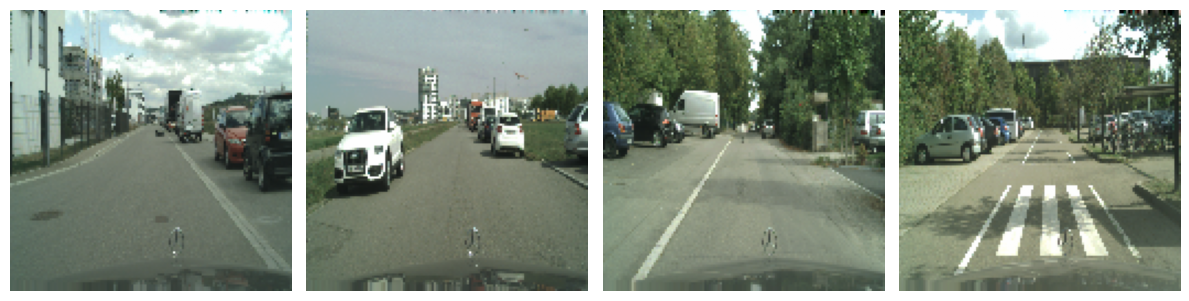

In [15]:
plt.figure(figsize=(12, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [17]:
# Split data into train/test sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# 2. Build Autoencoder to reconstruct images

In [25]:
# Create sequential autoencoder model
autoencoder = Sequential([
    # Encoder
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    
    # Decoder
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'), 
    UpSampling2D((2, 2)),
    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

c:\Users\909ca\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
autoencoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,347 (52.14 KB)

 Trainable params: 13,347 (52.14 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_data=(X_test, X_test))

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - loss: 0.6811 - val_loss: 0.6171
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - loss: 0.6106 - val_loss: 0.5999
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 0.5997 - val_loss: 0.5967
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - loss: 0.5956 - val_loss: 0.5960
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.5960 - val_loss: 0.5948
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 0.5928 - val_loss: 0.5926
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 0.5924 - val_loss: 0.5921
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - loss: 0.5919 - val_loss: 0.5917
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - loss: 0.5918 - val_loss: 0.5906
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.5907 - val_loss: 0.5901


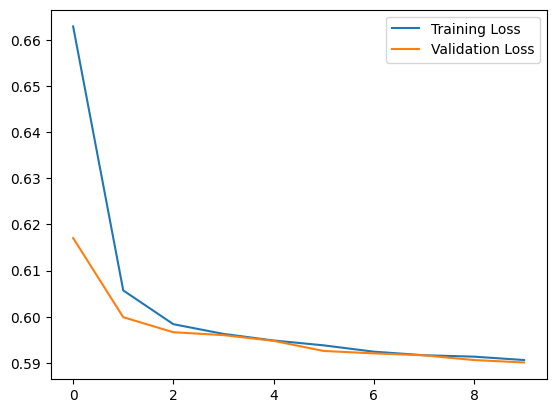

In [28]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


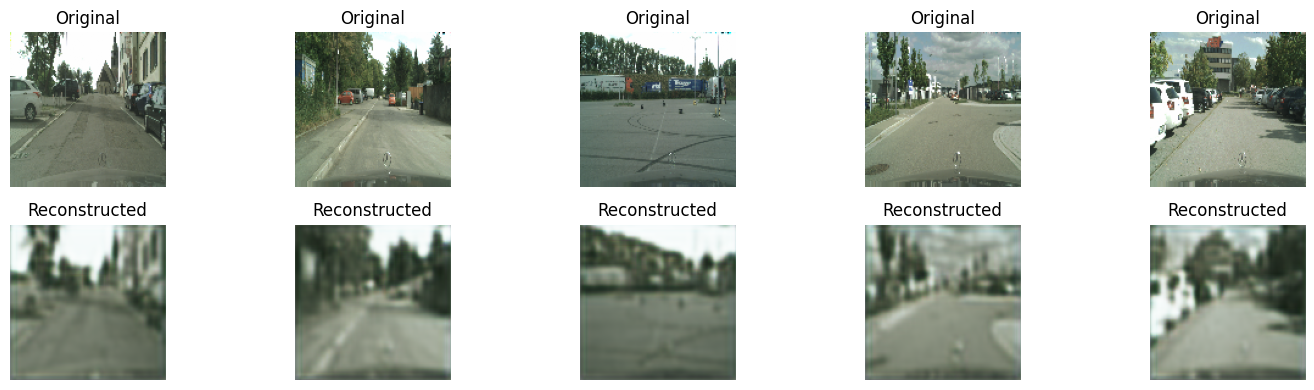

In [29]:
n_test = 5 # num test samples
decoded_imgs = autoencoder.predict(X_test[:n_test])

# original vs reconstructed images
plt.figure(figsize=(15, 4))
for i in range(n_test):
    # Original
    plt.subplot(2, n_test, i + 1)
    plt.imshow(X_test[i])
    plt.title('Original')
    plt.axis('off')
    
    # Reconstructed
    plt.subplot(2, n_test, i + n_test + 1)
    plt.imshow(decoded_imgs[i])
    plt.title('Reconstructed')
    plt.axis('off')
plt.tight_layout()
plt.show()

# 3. Build Anomaly Detection Model


In [41]:
# reconstruction error for training 
train_predictions = autoencoder.predict(X_train)
train_reconstruction_errors = np.mean(np.square(X_train - train_predictions), axis=(1,2,3))

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


In [42]:
# reconstruction error for test 
test_predictions = autoencoder.predict(X_test)
test_reconstruction_errors = np.mean(np.square(X_test - test_predictions), axis=(1,2,3))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [43]:
threshold_percentile = np.percentile(train_reconstruction_errors, 95)  # 95th percentile

In [44]:
# calculate anomalies with 95th percentile threshold
anomalies = test_reconstruction_errors > threshold_percentile
normal = test_reconstruction_errors <= threshold_percentile

print(f"\nNumber of anomalies detected: {np.sum(anomalies)}")
print(f"Number of normal samples: {np.sum(normal)}")
print(f"Anomaly percentage: {(np.sum(anomalies)/len(anomalies))*100:.2f}%")


Number of anomalies detected: 5
Number of normal samples: 195
Anomaly percentage: 2.50%


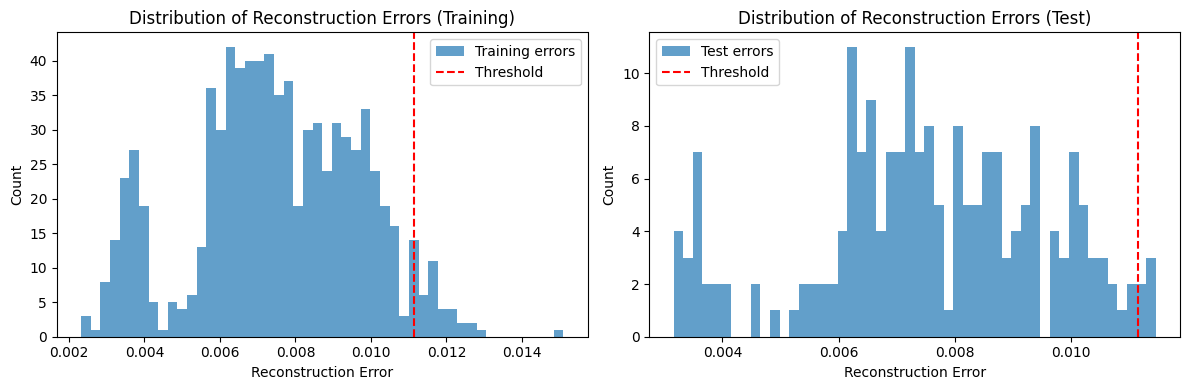

In [45]:
# plot reconstruction errors
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(train_reconstruction_errors, bins=50, alpha=0.7, label='Training errors')
plt.axvline(x=threshold_percentile, color='r', linestyle='--', label='Threshold')
plt.title('Distribution of Reconstruction Errors (Training)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(test_reconstruction_errors, bins=50, alpha=0.7, label='Test errors')
plt.axvline(x=threshold_percentile, color='r', linestyle='--', label='Threshold')
plt.title('Distribution of Reconstruction Errors (Test)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()